In [1]:
!pip install topmost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 49.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 95.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.3.1
    Uninstallin

In [2]:
import topmost
import os

In [12]:
device = "cuda"  # or "cpu"
dataset_dir = "/kaggle/input/revista-de-ciencias-mdicas-de-la-habana-cuba"
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

dataset = topmost.data.DynamicDataset(dataset_dir, batch_size=200, read_labels=True, device=device)

train size:  1208
test size:  658
vocab size:  19384
average length: 1335.378
num of each time slice:  22 [20 34 46 41 56 20 76 58 43 54 83 71 64 67 63 60 55 83 75 58 57 24]


In [4]:
import random
import joblib
import json
import os

In [5]:
def save_txt(obj, path):
    with open(path, 'w') as file:
        file.write(obj)

def save_top_words_txt(top_words, path):
    with open(os.path.join(path, 'top_words.txt'), 'w') as file:
        for i, time in enumerate(top_words):
            file.write(f'================= Time {i} ================= \n')
            for j, topic in enumerate(time):
                file.write(f'================= Topic {j} ================= \n')
                file.write(f'{topic}')
                file.write('\n')
            file.write('\n')

def save_json(obj, path):
    with open(path, 'w') as file:
        json.dump(obj, file)

def save_joblib(obj, path):
    joblib.dump(obj, path)

def save_result(top_words, trainer, config, metrics_json):
    global samples 
    path = os.path.join(output_dir, f'{samples}')
    os.makedirs(path, exist_ok=True)

    try:
        save_top_words_txt(top_words, path)
        save_json(config, os.path.join(path, 'hyperparameters.json'))
        save_json(metrics_json, os.path.join(path, 'metrics_json.json'))
        save_json({"config": config, "metrics": metrics_json}, os.path.join(path, 'metrics_config.json'))
        # save_joblib(trainer, os.path.join(path, 'trainer.joblib'))
        save_joblib(top_words, os.path.join(path, 'top_words.joblib'))
        print('🍀 Saved')
    except Exception as e:
        traceback.print_exc(e)        

def get_hyperparameter_space():
    return {
  "training": {
    "learning_rate": [0.001, 0.002, 0.005, 0.01],
    "batch_size": [100, 200, 300, 500],
    "num_epoch": [400, 600, 800, 1000]
  },
  "model": {
    "num_topics": [20, 50, 100],
    "en1_units": [50, 100, 200, 300],
    "dropout": [0.0, 0.1, 0.3, 0.5],
    "beta_temp": [0.5, 1.0, 1.5, 2.0],
    "temperature": [0.05, 0.1, 0.2, 0.5],
    "weight_neg": [1e6, 5e6, 1e7, 1e8],
    "weight_pos": [1.0, 10.0, 100.0],
    "weight_UWE": [1e2, 1e3, 1e4],
    "neg_topk": [5, 10, 15, 20, 30]
  }
}

def get_default_config():
    return { "training": {
                "learning_rate": 0.002,
                "batch_size": 200,
                "num_epoch": 800 },

            "model": {
                "num_topics": 50,
                "en1_units": 100,
                "dropout": 0. , 
                "beta_temp": 1.0,
                "temperature": 0.1,
                "weight_neg": 1.0e+7,
                "weight_pos": 1.0e+1,
                "weight_UWE": 1.0e+3,
                "neg_topk": 15 }
           }

def random_configuration(hyperparameter_space):
    return { "training": {
                "learning_rate": random.choice(hyperparameter_space["training"]["learning_rate"]),
                "batch_size": random.choice(hyperparameter_space["training"]["batch_size"]),
                "num_epoch": random.choice(hyperparameter_space["training"]["num_epoch"]) },

            "model": {
                "num_topics": random.choice(hyperparameter_space["model"]["num_topics"]),
                "en1_units": random.choice(hyperparameter_space["model"]["en1_units"]),
                "dropout": random.choice(hyperparameter_space["model"]["dropout"]) , 
                "beta_temp": random.choice(hyperparameter_space["model"]["beta_temp"]),
                "temperature": random.choice(hyperparameter_space["model"]["temperature"]),
                "weight_neg": random.choice(hyperparameter_space["model"]["weight_neg"]),
                "weight_pos": random.choice(hyperparameter_space["model"]["weight_pos"]),
                "weight_UWE": random.choice(hyperparameter_space["model"]["weight_UWE"]),
                "neg_topk":random.choice(hyperparameter_space["model"]["neg_topk"]) }
           }

## Hyperparameters Search

## - Evaluacion

In [6]:
########################### Evaluate ####################################
import numpy as np
from topmost import eva
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from topmost.data.file_utils import split_text_word

In [7]:
def _coherence_modified(reference_corpus, vocab, top_words, cv_type='c_v'):
    # print('🍀')
    
    split_top_words = split_text_word(top_words)
    num_top_words = len(split_top_words[0])
    for item in split_top_words:
        assert num_top_words == len(item)

    split_reference_corpus = split_text_word(reference_corpus)
    dictionary = Dictionary(split_text_word(vocab))

    cm = CoherenceModel(texts=split_reference_corpus, dictionary=dictionary, topics=split_top_words, topn=num_top_words, coherence=cv_type)
    cv_per_topic = cm.get_coherence_per_topic()
    # print(f"Coherence scores per topic: {cv_per_topic}")

    valid_scores = [score for score in cv_per_topic if not np.isnan(score)]
    if not valid_scores:
        # raise ValueError("All coherence scores are NaN.")
        return 0
    score = np.mean(valid_scores)

    return score
    
eva.topic_coherence._coherence = _coherence_modified

In [8]:
def eval(top_words, trainer):
    # get theta (doc-topic distributions)
    train_theta, test_theta = trainer.export_theta()

    train_times = dataset.train_times.cpu().numpy()
    # compute topic coherence
    dynamic_TC = eva.dynamic_coherence(dataset.train_texts, train_times, dataset.vocab, top_words)
    print("dynamic_TC: ", dynamic_TC)

    # compute topic diversity
    dynamic_TD = eva.dynamic_diversity(top_words, dataset.train_bow.cpu().numpy(), train_times, dataset.vocab)
    print("dynamic_TD: ", dynamic_TD)

    # evaluate clustering
    clustering = eva._clustering(test_theta, dataset.test_labels)
    print(clustering)

    # evaluate classification
    classification = eva._cls(train_theta, test_theta, dataset.train_labels, dataset.test_labels)
    print(classification)

    json = {
        "dynamic_TC": dynamic_TC,
        "dynamic_TD": dynamic_TD,
        "clustering": clustering,
        "classification": classification
    }
    
    return json, dynamic_TC, dynamic_TD, clustering, classification

## - Modelo

In [9]:
import traceback

In [ ]:
def evaluate_configuration(config):
    global tested_configs, samples
    
    config_key = json.dumps(config, sort_keys=True)  # Serializamos el diccionario como clave
    
    if config_key in tested_configs:
        return tested_configs[config_key]
    
    model = topmost.CFDTM(
        vocab_size=dataset.vocab_size,
        train_time_wordfreq=dataset.train_time_wordfreq,
        num_times=dataset.num_times,
        pretrained_WE=dataset.pretrained_WE,
        num_topics=config["model"]["num_topics"],
        en_units=config["model"]["en1_units"],
        temperature=config["model"]["temperature"],
        beta_temp=config["model"]["beta_temp"],
        weight_neg=config["model"]["weight_neg"],
        weight_pos=config["model"]["weight_pos"],
        weight_UWE=config["model"]["weight_UWE"],
        neg_topk=config["model"]["neg_topk"],
        dropout=config["model"]["dropout"],
        embed_size=300
    )
  
    model = model.to(device)  
    trainer = topmost.DynamicTrainer(model, dataset, batch_size=config["training"]["batch_size"], learning_rate=config["training"]["learning_rate"], epochs=config["training"]["num_epoch"])
    top_words, _ = trainer.train()
    
    try:
        metrics_json, dynamic_TC, dynamic_TD, clustering, classification = eval(top_words, trainer)
        #tested_configs[config_key] = 0.5 * dynamic_TC + 0.5 * dynamic_TD
        tested_configs[config_key] = {"dynamic_TC": dynamic_TC, "dynamic_TD": dynamic_TD}
        save_result(top_words, trainer, config, metrics_json)
        samples += 1
    except Exception as e:
        tested_configs[config_key] = {"dynamic_TC": float('-inf'), "dynamic_TD": float('-inf')}
        print(e)
        
    save_joblib(tested_configs, os.path.join(output_dir, 'tested_configs.joblib'))
    
    return tested_configs[config_key]

## - Algortimo evolutivo

In [ ]:
def evolutionary_search(search_space, generations=10, mutation_rate=0.1, population_size=20, population=None, generation_count=0):
    global samples
    
    if not population:
        population = [random_configuration(search_space) for _ in range(population_size - 1)]
        population.append(get_default_config())

    # print(population)
    
    for generation in range(generation_count, generations):
        scores = [(config, evaluate_configuration(config)) for config in population]
        scores.sort(key=lambda value: 0.5 * value[1]["dynamic_TC"] + 0.5 * value[1]["dynamic_TC"], reverse=True)  

        print(f"🧬 Generación {generation + 1}, mejor resultado: {scores[0][1]:.4f}")
        
        num_parents = population_size // 2
        parents = [config for config, _ in scores[:num_parents]]
        
        children = []
        while len(children) < population_size - num_parents:
            parent_1, parent_2 = random.sample(parents, 2)
            child = {
                "model": {key: random.choice([parent_1["model"][key], parent_2["model"][key]]) for key in search_space["model"].keys()},
                "training": {key: random.choice([parent_1["training"][key], parent_2["training"][key]]) for key in search_space["training"].keys()},
            }
            
            if random.random() < mutation_rate:
                mutate_model_training = random.choice(list(search_space.keys()))
                print(mutate_model_training)
                param_to_mutate = random.choice(list(search_space[mutate_model_training].keys()))
                print(param_to_mutate)
                child[mutate_model_training][param_to_mutate] = random.choice(search_space[mutate_model_training][param_to_mutate])
            
            children.append(child)
        
        population = parents + children
        joblib.dump(population, os.path.join(output_dir, 'population.joblib'))
    
    best_config, best_score = max(scores, key=lambda x: x[1])
    return best_config, best_score

## Main

In [ ]:
population_size = 50
# population = None
population = joblib.load(os.path.join(output_dir, 'population.joblib'))

In [ ]:
import joblib
# tested_configs = dict()
tested_configs = joblib.load('/kaggle/working/results/tested_configs.joblib')
# print(tested_configs)

In [ ]:
samples = len(results_path)

In [ ]:
hyperparameter_space = get_hyperparameter_space()

best_config, best_score = evolutionary_search(hyperparameter_space, population_size=population_size, generations=100, mutation_rate=0.2, population=population, generation_count=generation)
print(best_config)
print(best_score)

## Evaluando resultados

In [ ]:
import os
import json

results_path = '/kaggle/working/results'
results_path = [dir_.path for dir_ in os.scandir(results_path) if not dir_.is_file()]

print(len(results_path))

In [3]:
old_tc = float('-inf')
TC = []
old_td = float('-inf')
TD = []
old_tc_td = float('-inf')
TC_TD = []

for path in results_path:
    with open(os.path.join(path, 'metrics_json.json'), 'r') as file:
        metrics = json.load(file)

    cr_tc = metrics["dynamic_TC"]
    if cr_tc >= old_tc:
        with open(os.path.join(path, 'metrics_config.json'), 'r') as file:
            new = json.load(file)
        if cr_tc == old_tc:
            TC.append((new, path))
        else:
            old_tc = cr_tc
            TC = [(new, path)]

    cr_td = metrics["dynamic_TD"]
    if cr_td >= old_td:
        with open(os.path.join(path, 'metrics_config.json'), 'r') as file:
            new = json.load(file)
        if cr_td == old_td:
            TD.append((new, path))
        else:
            old_td = cr_td
            TD = [(new, path)]

    cr_tc_td = 0.5 * cr_tc + 0.5 * cr_td
    if cr_tc_td >= old_tc_td:
        with open(os.path.join(path, 'metrics_config.json'), 'r') as file:
            new = json.load(file)
        if cr_tc_td == old_tc_td:
            TC_TD.append((new, path))
        else:
            old_tc_td = cr_tc_td
            TC_TD = [(new, path)]

print(TC)
print(len(TC))
print('-------------------------------------')
print(TD)
print(len(TD))
print('-------------------------------------')
print(TC_TD)
print(len(TC_TD))

best_results_path = './best_results'
os.makedirs(best_results_path, exist_ok=True)
save_json(TC, os.path.join(best_results_path, 'best_tc.json'))
save_json(TD, os.path.join(best_results_path, 'best_td.json'))
save_json(TC_TD, os.path.join(best_results_path, 'best_tc_td.json'))

[({'config': {'training': {'learning_rate': 0.01, 'batch_size': 500, 'num_epoch': 1000}, 'model': {'num_topics': 100, 'en1_units': 50, 'dropout': 0.5, 'beta_temp': 1.5, 'temperature': 0.2, 'weight_neg': 5000000.0, 'weight_pos': 100.0, 'weight_UWE': 10000.0, 'neg_topk': 10}}, 'metrics': {'dynamic_TC': 0.6263097214101826, 'dynamic_TD': 0.335939393939394, 'clustering': {'Purity': 0.34498480243161095, 'NMI': 0.21334602154627538}, 'classification': {'acc': 0.3541033434650456, 'macro-F1': 0.12100456580356023}}}, '/kaggle/working/results/55')]
1
-------------------------------------
[({'config': {'model': {'num_topics': 20, 'en1_units': 50, 'dropout': 0.1, 'beta_temp': 1.5, 'temperature': 0.1, 'weight_neg': 5000000.0, 'weight_pos': 100.0, 'weight_UWE': 10000.0, 'neg_topk': 20}, 'training': {'learning_rate': 0.001, 'batch_size': 500, 'num_epoch': 800}}, 'metrics': {'dynamic_TC': 0.5281898315085433, 'dynamic_TD': 0.941060606060606, 'clustering': {'Purity': 0.3844984802431611, 'NMI': 0.273024515

In [2]:
!zip -r best_results/best_results.zip /kaggle/working/results/84

updating: kaggle/working/results/84/ (stored 0%)
updating: kaggle/working/results/84/top_words.joblib (deflated 73%)
updating: kaggle/working/results/84/top_words.txt (deflated 80%)
updating: kaggle/working/results/84/metrics_json.json (deflated 29%)
updating: kaggle/working/results/84/hyperparameters.json (deflated 38%)
updating: kaggle/working/results/84/metrics_config.json (deflated 40%)


In [ ]:
import joblib
top_words = joblib.load('/kaggle/working/results/84/top_words.joblib')
print(top_words)

## Prueba unica

In [13]:
        config = {"model": {"num_topics": 20, "en1_units": 50, "dropout": 0.1, "beta_temp": 1.5, "temperature": 0.1, "weight_neg": 5000000.0, "weight_pos": 100.0, "weight_UWE": 10000.0, "neg_topk": 20}, "training": {"learning_rate": 0.001, "batch_size": 500, "num_epoch": 800}}

        model = topmost.CFDTM(
        vocab_size=dataset.vocab_size,
        train_time_wordfreq=dataset.train_time_wordfreq,
        num_times=dataset.num_times,
        pretrained_WE=dataset.pretrained_WE,
        num_topics=config["model"]["num_topics"],
        en_units=config["model"]["en1_units"],
        temperature=config["model"]["temperature"],
        beta_temp=config["model"]["beta_temp"],
        weight_neg=config["model"]["weight_neg"],
        weight_pos=config["model"]["weight_pos"],
        weight_UWE=config["model"]["weight_UWE"],
        neg_topk=config["model"]["neg_topk"],
        dropout=config["model"]["dropout"],
        embed_size=300
        )
  
        model = model.to(device)  
        trainer = topmost.DynamicTrainer(model, dataset, batch_size=config["training"]["batch_size"], learning_rate=config["training"]["learning_rate"], epochs=config["training"]["num_epoch"])
        top_words, _ = trainer.train()
        metrics_json, dynamic_TC, dynamic_TD, clustering, classification = eval(top_words, trainer)

100%|██████████| 800/800 [10:50<00:00,  1.23it/s]
22it [00:52,  2.39s/it]


dynamic_TC:  0.5134656570389191


100%|██████████| 22/22 [00:00<00:00, 71.17it/s]


dynamic_TD:  0.9148484848484849
{'Purity': 0.44224924012158057, 'NMI': 0.32578741440221265}
{'acc': 0.44376899696048633, 'macro-F1': 0.2559157012257026}


 ## beta (================= es este)

In [3]:
import joblib
#beta = model.get_beta()
#print(beta)
beta = joblib.load('top_words/beta.joblib')

#joblib.dump(beta, 'top_words/beta.joblib')

In [9]:
print(beta.shape[0])
print(beta.shape[1])
print(beta.shape[2])

22
20
19384


In [ ]:
path = './visualize'
os.makedirs(path, exist_ok=True)

In [10]:
import torch
def get_top_words(num=10):
    top_words_path = f'./top_words/{num}top_words_per_topics_model149'
    path_0 = os.path.join(top_words_path, 'separate_by_space')
    path_1 = os.path.join(top_words_path, 'separate_by_\n')
    # os.makedirs(top_words_path, exist_ok=True)
    os.makedirs(path_0, exist_ok=True)
    os.makedirs(path_1, exist_ok=True)

    top_words = []
    for topic in range(beta.shape[1]):
        # el range comienza en 9 para comenzar a partir del anno 2010
        top_words.append([[vocab[idx.item()] for idx in torch.topk(beta[time][topic], k=num).indices] for time in range(9, beta.shape[0])])
    # print(len(top_words))
    # print(len(top_words[0]))
    joblib.dump(top_words, f'{top_words_path}/{num}top_words_topic_149.joblib')

    print('Numero de topicos: ', len(top_words))
    print('Numero de annos: ', len(top_words[0]))

    
    for j, topic in enumerate(top_words):
        text = '' # 'Time 2003-2024 \n\n'
        text_1 = ''
        for i, time in enumerate(topic):
            text += f'{2012 + i}: ' + ' '.join(time) + '\n\n'
            text_1 += f'{2012 + i}\n' + '\n'.join(time) + '\n\n'
        with open(os.path.join(path_0, f'{j}.txt'), 'w') as file:
            file.write(text)
        with open(os.path.join(path_1, f'{j}.txt'), 'w') as file:
            file.write(text_1)

In [12]:
!zip -r /kaggle/working/top_words/top_words_per_topics_model149.zip /kaggle/working/top_words

updating: kaggle/working/top_words/ (stored 0%)
updating: kaggle/working/top_words/15top_words_per_topics_model149/ (stored 0%)
updating: kaggle/working/top_words/15top_words_per_topics_model149/separate_by_^J/ (stored 0%)
updating: kaggle/working/top_words/15top_words_per_topics_model149/separate_by_^J/18.txt (deflated 73%)
updating: kaggle/working/top_words/15top_words_per_topics_model149/separate_by_^J/16.txt (deflated 69%)
updating: kaggle/working/top_words/15top_words_per_topics_model149/separate_by_^J/8.txt (deflated 67%)
updating: kaggle/working/top_words/15top_words_per_topics_model149/separate_by_^J/11.txt (deflated 64%)
updating: kaggle/working/top_words/15top_words_per_topics_model149/separate_by_^J/1.txt (deflated 72%)
updating: kaggle/working/top_words/15top_words_per_topics_model149/separate_by_^J/10.txt (deflated 71%)
updating: kaggle/working/top_words/15top_words_per_topics_model149/separate_by_^J/15.txt (deflated 63%)
updating: kaggle/working/top_words/15top_words_per_

In [5]:
import os
vocab_path = '/kaggle/input/revista-de-ciencias-mdicas-de-la-habana-cuba/vocab.txt'
with open(vocab_path, 'r') as file:
    words = file.readlines()
    vocab = [word.replace('\n', '') for word in words]

In [11]:
for num in [10, 15, 20, 25, 30]:
    get_top_words(num)

Numero de topicos:  20
Numero de annos:  13
Numero de topicos:  20
Numero de annos:  13
Numero de topicos:  20
Numero de annos:  13
Numero de topicos:  20
Numero de annos:  13
Numero de topicos:  20
Numero de annos:  13


In [ ]:
for num in [10, 15, 20, 25, 30]:
    os.remove(f'/kaggle/working/{num}top_words_topic_149.joblib')

## Visualizar heatmap

## Visualize (================= es este)

In [1]:
import os
vocab_path = '/kaggle/input/revista-de-ciencias-mdicas-de-la-habana-cuba/vocab.txt'
with open(vocab_path, 'r') as file:
    words = file.readlines()
    vocab = [word.replace('\n', '') for word in words]

import joblib
beta = joblib.load('top_words/beta.joblib')

In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.4 MB/s eta 0:00:00a 0:00:01


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_mapa_color(words, word_idxs, topic_name, path, annot_kws_size=8):
    data = dict()
    for time in range(9, 22):
        for word_idx in word_idxs:
            data[2003 + time] = data.get(2003 + time, []) + [beta[time][topic][word_idx].item()]

    # Convertir el diccionario en un DataFrame de pandas
    df = pd.DataFrame(data, index=words)

    # Crear el mapa de calor
    plt.figure(figsize=(10, 8))
    #sns.heatmap(df, cmap='Spectral', annot=True, fmt='d', cbar=True)
    sns.heatmap(df, cmap='Reds', annot=True, fmt='.2f', cbar=True, annot_kws={'size': annot_kws_size})
    #sns.heatmap(df, cmap='Blues', annot=True, fmt='d', cbar=True)
    #sns.heatmap(df, cmap='Reds', annot=True, fmt='d', cbar=True)

    # Títulos y etiquetas
    plt.title(f"Mapa de Calor de Palabras por Año. {topic_name}", fontsize=16)
    plt.xlabel("Año", fontsize=10)
    plt.ylabel("Palabras Clave", fontsize=12)

    # Mostrar el gráfico
    plt.savefig(path)
    plt.show()


In [3]:
from unidecode import unidecode
images_path = './images'

def get_word_index(word):
    return vocab.index(unidecode(word)) 

### Topic 0

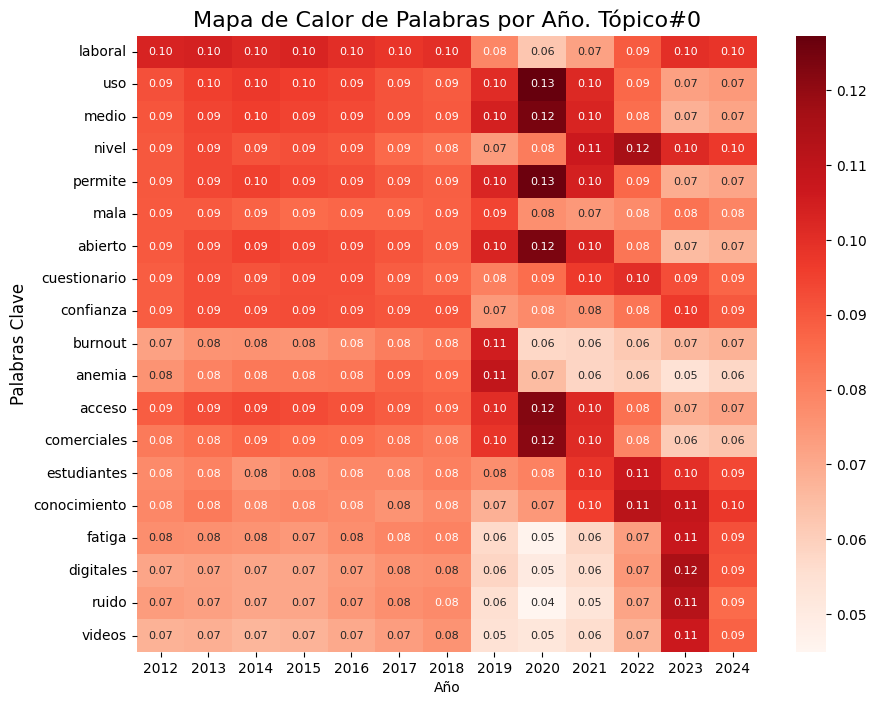

In [6]:
topic = 0
topic_name = 'Tópico#0'
topic_path_img = f'{images_path}/topic_0/probabilidad.png'
os.makedirs(f'{images_path}/topic_0', exist_ok=True)
topic_path_img = f'{images_path}/topic_0/mapa_de_color.png'

words = ['laboral', 'uso', 'medio', 'nivel', 'permite', 'mala', 'abierto', 'cuestionario', 
             'confianza', 'burnout', 'anemia', 'acceso', 'comerciales', 'estudiantes', 'conocimiento', 
             'fatiga', 'digitales', 'ruido', 'videos']
word_index = [get_word_index(word) for word in words] 
get_mapa_color(words, word_index, topic_name, topic_path_img)

## Topico 1

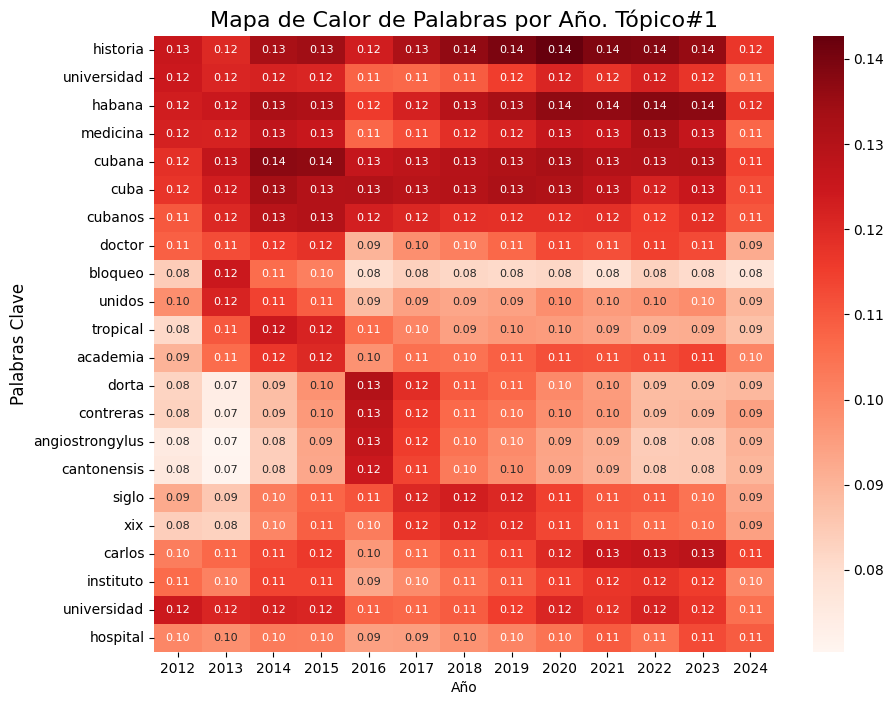

In [7]:
import os
topic = 1
topic_name = f'Tópico#{topic}'
os.makedirs(f'{images_path}/topic_{topic}', exist_ok=True)
# topic_path_img = f'{images_path}/topic_0/probabilidad.png'
topic_path_img = f'{images_path}/topic_{topic}/mapa_de_color.png'

words = [
    'historia', 'universidad', 'habana', 'medicina', 'cubana', 'cuba', 'cubanos', 'doctor', 'bloqueo', 'unidos', 'tropical', 'academia',
    'dorta', 'contreras', 'angiostrongylus', 'cantonensis', 'siglo', 'xix', 'carlos', 'instituto', 'universidad', 'hospital'
]

word_index = [get_word_index(word) for word in words]       
get_mapa_color(words, word_index, topic_name, topic_path_img)

# Topic 3

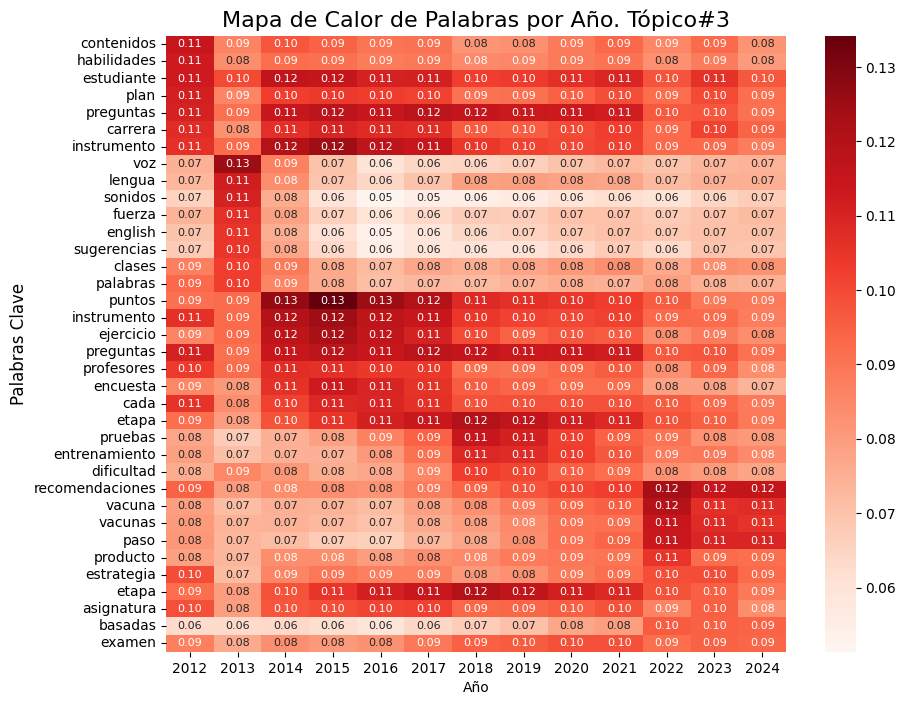

In [8]:
import os
topic = 3
topic_name = f'Tópico#{topic}'
os.makedirs(f'{images_path}/topic_{topic}', exist_ok=True)
# topic_path_img = f'{images_path}/topic_0/probabilidad.png'
topic_path_img = f'{images_path}/topic_{topic}/mapa_de_color.png'

words = [
    'contenidos', 'habilidades', 'estudiante', 'plan', 'preguntas', 'carrera', 'instrumento', 'voz', 'lengua', 'sonidos', 'fuerza', 'english', 
    'sugerencias', 'clases', 'palabras', 'puntos', 'instrumento', 'ejercicio', 'preguntas', 'profesores', 'encuesta', 'cada', 'etapa', 
    'pruebas', 'entrenamiento', 'dificultad', 'recomendaciones', 'vacuna', 'vacunas', 'paso', 'producto','estrategia', 'etapa',
    'asignatura', 'basadas', 'examen'
]

get_mapa_color(words, word_index, topic_name, topic_path_img)

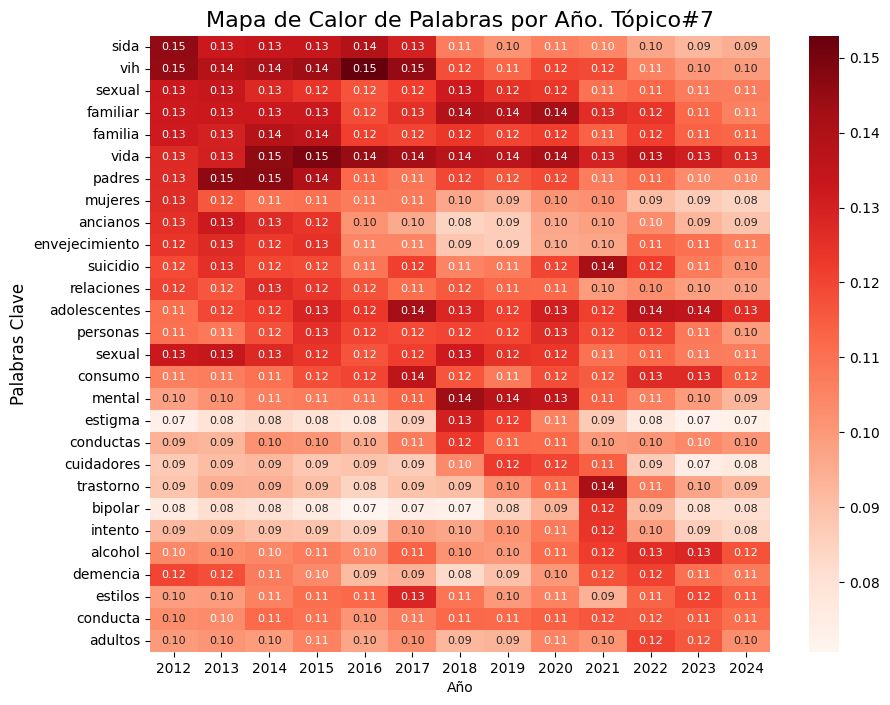

In [9]:
import os
topic = 7
topic_name = f'Tópico#{topic}'
os.makedirs(f'{images_path}/topic_{topic}', exist_ok=True)
# topic_path_img = f'{images_path}/topic_0/probabilidad.png'
topic_path_img = f'{images_path}/topic_{topic}/mapa_de_color.png'

words = [
    'sida', 'vih', 'sexual', 'familiar', 'familia', 'vida', 'padres', 'mujeres', 'ancianos', 'envejecimiento', 'suicidio', 'relaciones', 'adolescentes',
    'personas', 'sexual', 'consumo', 'mental', 'estigma', 'conductas', 'cuidadores', 'trastorno', 'bipolar', 'intento', 'alcohol', 'demencia', 'estilos',
     'conducta', 'adultos'
]

get_mapa_color(words, word_index, topic_name, topic_path_img)

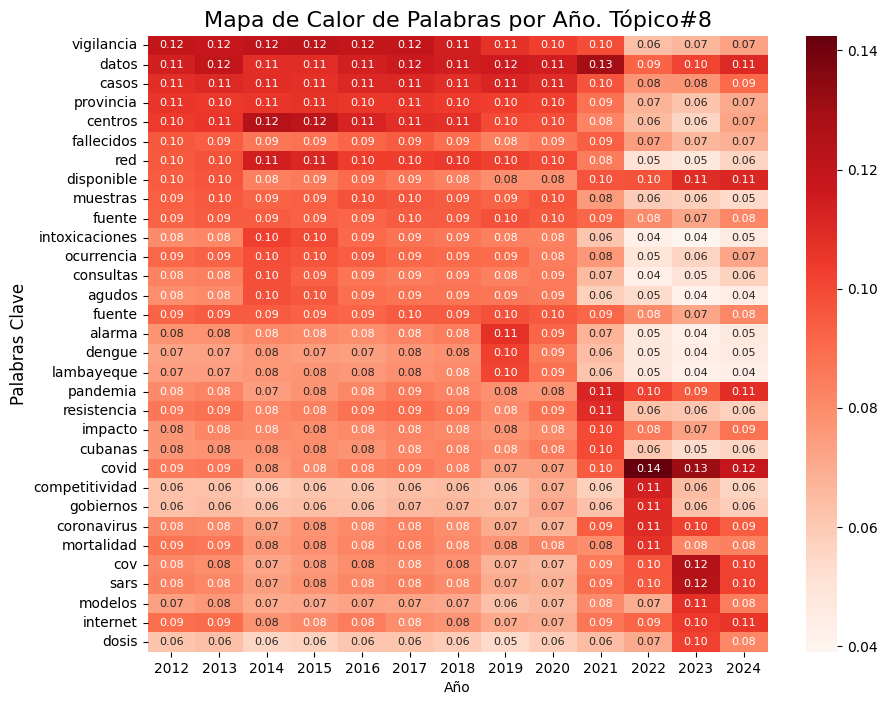

In [10]:
import os
topic = 8
topic_name = f'Tópico#{topic}'
os.makedirs(f'{images_path}/topic_{topic}', exist_ok=True)
# topic_path_img = f'{images_path}/topic_0/probabilidad.png'
topic_path_img = f'{images_path}/topic_{topic}/mapa_de_color.png'

words = [ 'vigilancia', 'datos', 'casos', 'provincia', 'centros', 'fallecidos', 'red', 'disponible', 'muestras', 'fuente', 'intoxicaciones', 'ocurrencia',
         'consultas', 'agudos', 'fuente', 'alarma', 'dengue', 'lambayeque', 'pandemia', 'resistencia', 'impacto',
'cubanas', 'covid', 'competitividad', 'gobiernos', 'coronavirus', 'mortalidad', 'cov', 'sars', 'modelos', 'internet', 'dosis'
]

get_mapa_color(words, word_index, topic_name, topic_path_img)

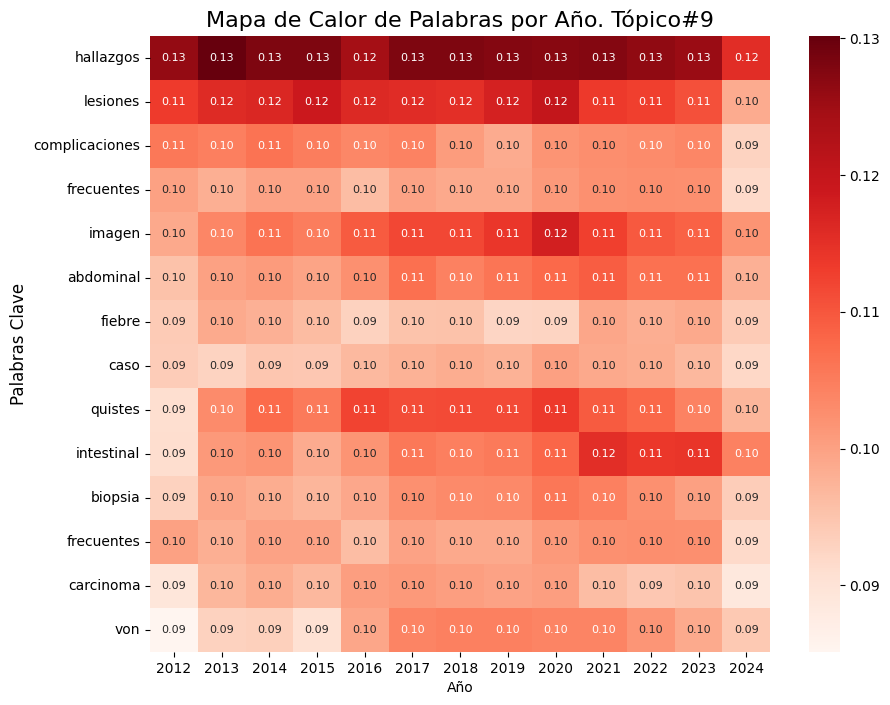

In [11]:
import os
topic = 9
topic_name = f'Tópico#{topic}'
os.makedirs(f'{images_path}/topic_{topic}', exist_ok=True)
# topic_path_img = f'{images_path}/topic_0/probabilidad.png'
topic_path_img = f'{images_path}/topic_{topic}/mapa_de_color.png'

words = [ 'hallazgos', 'lesiones', 'complicaciones', 'frecuentes', 'imagen', 'abdominal', 'fiebre', 'caso',  'quistes', 'intestinal', 'biopsia', 'frecuentes',
         'carcinoma', 'von']

get_mapa_color(words, word_index, topic_name, topic_path_img)

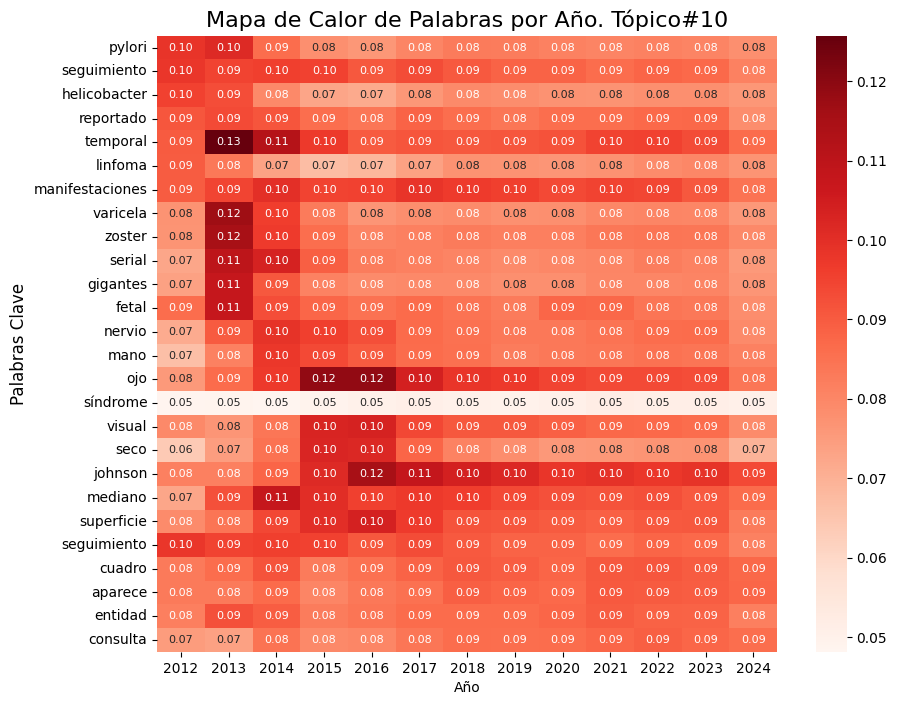

In [12]:
import os
topic = 10
topic_name = f'Tópico#{topic}'
os.makedirs(f'{images_path}/topic_{topic}', exist_ok=True)
# topic_path_img = f'{images_path}/topic_0/probabilidad.png'
topic_path_img = f'{images_path}/topic_{topic}/mapa_de_color.png'

words = [
    'pylori', 'seguimiento', 'helicobacter', 'reportado', 'temporal',
'linfoma', 'manifestaciones', 'varicela', 'zoster', 'serial',
'gigantes', 'fetal', 'nervio', 'mano', 'ojo', 'síndrome', 'visual', 'seco', 
    'johnson', 'mediano', 'superficie', 'seguimiento', 'cuadro', 
    'aparece', 'entidad', 'consulta'
]

get_mapa_color(words, word_index, topic_name, topic_path_img)

In [13]:
!zip -r /kaggle/working/images.zip /kaggle/working/images

  adding: kaggle/working/images/ (stored 0%)
  adding: kaggle/working/images/topic_7/ (stored 0%)
  adding: kaggle/working/images/topic_7/mapa_de_color.png (deflated 5%)
  adding: kaggle/working/images/topic_1/ (stored 0%)
  adding: kaggle/working/images/topic_1/mapa_de_color.png (deflated 6%)
  adding: kaggle/working/images/topic_9/ (stored 0%)
  adding: kaggle/working/images/topic_9/mapa_de_color.png (deflated 8%)
  adding: kaggle/working/images/topic_0/ (stored 0%)
  adding: kaggle/working/images/topic_0/mapa_de_color.png (deflated 6%)
  adding: kaggle/working/images/topic_0/probabilidad.png (deflated 5%)
  adding: kaggle/working/images/topic_10/ (stored 0%)
  adding: kaggle/working/images/topic_10/mapa_de_color.png (deflated 5%)
  adding: kaggle/working/images/topic_8/ (stored 0%)
  adding: kaggle/working/images/topic_8/mapa_de_color.png (deflated 4%)
  adding: kaggle/working/images/topic_3/ (stored 0%)
  adding: kaggle/working/images/topic_3/mapa_de_color.png (deflated 4%)
